# LSTM5: Multivariate encoder-decoder LSTM model with prior one week’s data as the input

In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential,Model
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import time
import tensorflow as tf
from keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, concatenate

In [ ]:
data = pd.read_csv('imputed_dataset.csv')
train_data = pd.read_csv('training_data.csv')
test_data = pd.read_csv('testing_data.csv')

In [ ]:
train_data = train_data[['Open','High','Low','Close','Volume','Range']]
test_data = test_data[['Open','High','Low','Close','Volume','Range']]

In [ ]:
from scipy.stats import pearsonr

def pearson_correlation(actual, predicted):
    actual = actual * (data['Open'].max() - data['Open'].min()) + data['Open'].min()
    predicted = predicted *  (data['Open'].max() - data['Open'].min()) + data['Open'].min()
    correlation, _ = pearsonr(actual, predicted)
    return correlation

def evaluate_rmse_ratio(actual, predicted):
    actual = actual * (data['Open'].max() - data['Open'].min()) + data['Open'].min()
    predicted = predicted *  (data['Open'].max() - data['Open'].min()) + data['Open'].min()
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return rmse

def calculate_rmse_per_day(y_true, y_pred):
    y_true = y_true * (data['Open'].max() - data['Open'].min()) + data['Open'].min()
    y_pred = y_pred *  (data['Open'].max() - data['Open'].min()) + data['Open'].min()
    rmse_per_day = []
    for i in range(5):
        rmse_per_day.append(np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i])))
    return rmse_per_day

In [ ]:
def create_dataset(dataset, time_step=5, forecast_horizon=5):
    dataset = np.array(dataset)
    X, Y = [], []
    for i in range(len(dataset) - time_step - forecast_horizon + 1):
        X.append(dataset[i:(i + time_step), 1:6])
        Y.append(dataset[(i + time_step):(i + time_step + forecast_horizon), 0])
    return np.array(X), np.array(Y)

In [ ]:
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

In [ ]:
def build_encoder_decoder_lstm():
    # Encoder
    encoder_inputs = Input(shape=(5, 5))
    encoder_lstm = LSTM(200, activation='relu')(encoder_inputs)

    # Repeat vector
    repeat_vector = RepeatVector(5)(encoder_lstm)

    # Decoder
    decoder_lstm = LSTM(200, activation='relu', return_sequences=True)(repeat_vector)
    decoder_dense = TimeDistributed(Dense(100, activation='relu'))(decoder_lstm)
    outputs = TimeDistributed(Dense(1))(decoder_dense)

    model = Model(inputs=encoder_inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

In [ ]:
rmse_list = []
execution_time_list = []
corr_list = []
for i in range(10):
    start_time = time.time()

    fourth_model = build_encoder_decoder_lstm()

    history = fourth_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    predictions = fourth_model.predict(X_test)

    end_time = time.time()
    execution_time = end_time - start_time
    rmse = evaluate_rmse_ratio(y_test.reshape(-1,1), predictions.reshape(-1,1))
    rmse_list.append(rmse)
    execution_time_list.append(execution_time)
    rmse_per_day = calculate_rmse_per_day(y_test, predictions)
    #Correlation
    corr = pearson_correlation(y_test.flatten(), predictions.flatten())
    corr_list.append(corr)
    for j, item in enumerate(rmse_per_day):
        print(f'RMSE for day {j+2}: {item}')
    print(f"Round {i+1}: Loss = {history.history['loss'][-1]}, RMSE = {rmse}, Execution time = {execution_time}, Correlation = {corr}")

13/13 [==============================] - 1s 16ms/step
RMSE for day 2: 140.0824788708331
RMSE for day 3: 225.0103655986633
RMSE for day 4: 273.71562864084535
RMSE for day 5: 310.57523773099786
RMSE for day 6: 359.21230473528755
Round 1: Loss = 0.0005804129177704453, RMSE = 272.2731970064617, Execution time = 85.90833067893982, Correlation = 0.9729112489168098
13/13 [==============================] - 0s 11ms/step
RMSE for day 2: 199.93640542476822
RMSE for day 3: 191.78976389362612
RMSE for day 4: 238.53282006535082
RMSE for day 5: 280.1854489309857
RMSE for day 6: 330.68351701571083
Round 2: Loss = 0.0005887599545530975, RMSE = 253.57888721871822, Execution time = 86.17186117172241, Correlation = 0.9737729749583233
13/13 [==============================] - 0s 9ms/step
RMSE for day 2: 173.02979382726934
RMSE for day 3: 249.05681886526907
RMSE for day 4: 299.0651439425633
RMSE for day 5: 337.01877512354463
RMSE for day 6: 381.4641891429205
Round 3: Loss = 0.0005343708326108754, RMSE = 296.

In [ ]:
np.mean(rmse_list)/data['Open'].mean()

0.026720472815699885

In [ ]:
np.mean(execution_time_list)

83.72916200160981

In [ ]:
np.mean(corr_list)

0.9727657454267554

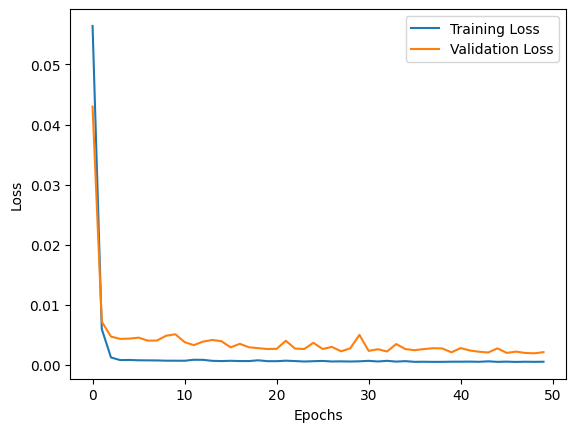

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()